# [NTDS'19] assignment 1: network science
[ntds'19]: https://github.com/mdeff/ntds_2019

[Eda Bayram](https://lts4.epfl.ch/bayram), [EPFL LTS4](https://lts4.epfl.ch) and
[Nikolaos Karalias](https://people.epfl.ch/nikolaos.karalias), [EPFL LTS2](https://lts2.epfl.ch).

## Students

* Team: 17
* Students: Ljupche Milosheski

## Rules

Grading:
* The first deadline is for individual submissions. The second deadline is for the team submission.
* All team members will receive the same grade based on the team solution submitted on the second deadline.
* As a fallback, a team can ask for individual grading. In that case, solutions submitted on the first deadline are graded.
* Collaboration between team members is encouraged. No collaboration between teams is allowed.

Submission:
* Textual answers shall be short. Typically one to two sentences.
* Code has to be clean.
* You cannot import any other library than we imported.
  Note that Networkx is imported in the second section and cannot be used in the first.
* When submitting, the notebook is executed and the results are stored. I.e., if you open the notebook again it should show numerical results and plots. We won't be able to execute your notebooks.
* The notebook is re-executed from a blank state before submission. That is to be sure it is reproducible. You can click "Kernel" then "Restart Kernel and Run All Cells" in Jupyter.

## Objective

The purpose of this milestone is to explore a given dataset, represent it by network by constructing different graphs. In the first section, you will analyze the network properties. In the second section, you will explore various network models and find out the network model fitting the ones you construct from the dataset.

## Cora Dataset

The [Cora dataset](https://linqs.soe.ucsc.edu/node/236) consists of scientific publications classified into one of seven research fields. 

* **Citation graph:** the citation network can be constructed from the connections given in the `cora.cites` file.
* **Feature graph:** each publication in the dataset is described by a 0/1-valued word vector indicating the absence/presence of the corresponding word from the dictionary and its research field, given in the `cora.content` file. The dictionary consists of 1433 unique words. A feature graph can be constructed using the Euclidean distance between the feature vector of the publications.

The [`README`](data/cora/README) provides details about the content of [`cora.cites`](data/cora/cora.cites) and [`cora.content`](data/cora/cora.content).

## Section 1: Network Properties

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

%matplotlib inline

### Question 1: Construct a Citation Graph and a Feature Graph

Read the `cora.content` file into a Pandas DataFrame by setting a header for the column names. Check the `README` file.

In [2]:
column_list =  ["paper_id"] + ["word_attribute_" + str(i) for i in range(1433)] + ["class_label"]
pd_content = pd.read_csv('data/cora/cora.content', delimiter='\t', names=column_list) 
pd_content.head()

,paper_id,word_attribute_0,word_attribute_1,word_attribute_2,word_attribute_3,word_attribute_4,word_attribute_5,word_attribute_6,word_attribute_7,word_attribute_8,...,word_attribute_1424,word_attribute_1425,word_attribute_1426,word_attribute_1427,word_attribute_1428,word_attribute_1429,word_attribute_1430,word_attribute_1431,word_attribute_1432,class_label
0,31336,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,Neural_Networks
1,1061127,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,Rule_Learning
2,1106406,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Reinforcement_Learning
3,13195,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Reinforcement_Learning
4,37879,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Probabilistic_Methods


Print out the number of papers contained in each of the reasearch fields.

**Hint:** You can use the `value_counts()` function.

In [3]:
pd_content["class_label"].value_counts()

Neural_Networks           818
Probabilistic_Methods     426
Genetic_Algorithms        418
Theory                    351
Case_Based                298
Reinforcement_Learning    217
Rule_Learning             180
Name: class_label, dtype: int64

Select all papers from a field of your choice and store their feature vectors into a NumPy array.
Check its shape.

In [4]:
my_field = "Rule_Learning"
features = pd_content[pd_content["class_label"] == my_field].iloc[:, 1:-1].values
features.shape

(180, 1433)

Let $D$ be the Euclidean distance matrix whose $(i,j)$ entry corresponds to the Euclidean distance between feature vectors $i$ and $j$.
Using the feature vectors of the papers from the field which you have selected, construct $D$ as a Numpy array. 

In [5]:
rows, cols = np.indices((features.shape[0], features.shape[0]))
distance = np.sqrt(np.sum((features[rows, :] - features[cols, :])**2, axis=2))
distance.shape

(180, 180)

Check the mean pairwise distance $\mathbb{E}[D]$.

In [6]:
mean_distance = distance.mean()
mean_distance

5.822492039380866

Plot an histogram of the euclidean distances.

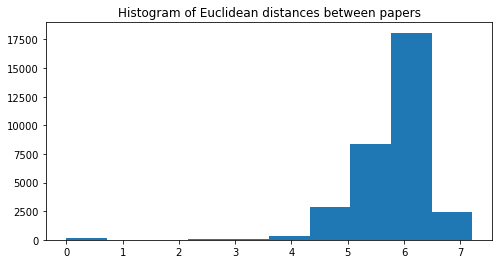

In [7]:
plt.figure(1, figsize=(8, 4))
plt.title("Histogram of Euclidean distances between papers")
plt.hist(distance.flatten());

Now create an adjacency matrix for the papers by thresholding the Euclidean distance matrix.
The resulting (unweighted) adjacency matrix should have entries
$$ A_{ij} = \begin{cases} 1, \; \text{if} \; d(i,j)< \mathbb{E}[D], \; i \neq j, \\ 0, \; \text{otherwise.} \end{cases} $$

First, let us choose the mean distance as the threshold.

In [8]:
threshold = mean_distance
A_feature = (distance < threshold).astype(int) - np.identity(distance.shape[0])

Now read the `cora.cites` file and construct the citation graph by converting the given citation connections into an adjacency matrix.

In [9]:
cora_cites = np.genfromtxt('data/cora/cora.cites', delimiter='\t')
dic = { value: i for i, value in enumerate(pd_content["paper_id"]) }
cora_cities_indices = [ [dic[x[0]], dic[x[1]]] for x in cora_cites ]
A_citation = np.zeros((pd_content.shape[0], pd_content.shape[0]))
for r in cora_cities_indices:
    A_citation[r[1], r[0]] = 1
A_citation.shape

(2708, 2708)

Get the adjacency matrix of the citation graph for the field that you chose.
You have to appropriately reduce the adjacency matrix of the citation graph.

In [10]:
index = pd_content[pd_content["class_label"] == my_field].index.values
A_citation = A_citation[index, :][:, index]

Check if your adjacency matrix is symmetric. Symmetrize your final adjacency matrix if it's not already symmetric.

In [11]:
A_citation = A_citation + A_citation.T
# There is an issue with the data. Two papers cite each other.
A_citation[A_citation == 2] = 1

np.count_nonzero(A_citation - A_citation.transpose())

0

Check the shape of your adjacency matrix again.

In [12]:
A_citation.shape

(180, 180)

### Question 2: Degree Distribution and Moments

What is the total number of edges in each graph?

In [13]:
num_edges_feature = int(np.sum(A_feature) / 2)
num_edges_citation = int(np.sum(A_citation) / 2)
print(f"Number of edges in the feature graph: {num_edges_feature}")
print(f"Number of edges in the citation graph: {num_edges_citation}")

Number of edges in the feature graph: 5829
Number of edges in the citation graph: 253


Plot the degree distribution histogram for each of the graphs.

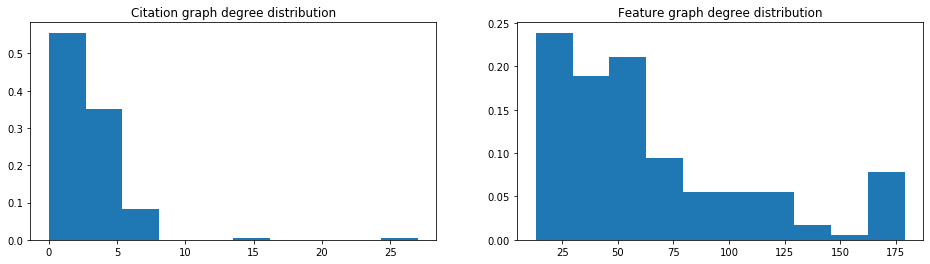

In [14]:
degrees_citation = np.sum(A_citation, axis=0).astype(int)
degrees_feature = np.sum(A_feature, axis=0).astype(int)

deg_hist_normalization = np.ones(degrees_citation.shape[0]) / degrees_citation.shape[0]

fig, axes = plt.subplots(1, 2, figsize=(16, 4))
axes[0].set_title('Citation graph degree distribution')
axes[0].hist(degrees_citation, weights=deg_hist_normalization);
axes[1].set_title('Feature graph degree distribution')
axes[1].hist(degrees_feature, weights=deg_hist_normalization);

Calculate the first and second moments of the degree distribution of each graph.

In [15]:
cit_moment_1 = np.sum(degrees_citation ** 1) / degrees_citation.shape[0]
cit_moment_2 = np.sum(degrees_citation ** 2) / degrees_citation.shape[0]

feat_moment_1 = np.sum(degrees_feature ** 1) / degrees_feature.shape[0]
feat_moment_2 = np.sum(degrees_feature ** 2) / degrees_feature.shape[0]

print(f"1st moment of citation graph: {cit_moment_1}")
print(f"2nd moment of citation graph: {cit_moment_2}")
print(f"1st moment of feature graph: {feat_moment_1}")
print(f"2nd moment of feature graph: {feat_moment_2}")

print(f"\nStandard deviation of citation graph: {np.sqrt(cit_moment_2 - cit_moment_1**2)}")
print(f"Standard deviation of feature graph: {np.sqrt(feat_moment_2 - feat_moment_1**2)}")

1st moment of citation graph: 2.811111111111111
2nd moment of citation graph: 15.233333333333333
1st moment of feature graph: 64.76666666666667
2nd moment of feature graph: 6183.166666666667

Standard deviation of citation graph: 2.7075796672159043
Standard deviation of feature graph: 44.591989813816966


What information do the moments provide you about the graphs?
Explain the differences in moments between graphs by comparing their degree distributions.

**Your answer here:**

By looking at the degree distributions, it is obvious that the second graph will have greater first moment (mean degree), because there are nodes which have a higher degree than almost any other node in the citation graph. Also, the degree distribution of the second graph is more spread out, thus the second moment is greater than the second moment of the first graph.

Select the 20 largest hubs for each of the graphs and remove them. Observe the sparsity pattern of the adjacency matrices of the citation and feature graphs before and after such a reduction.

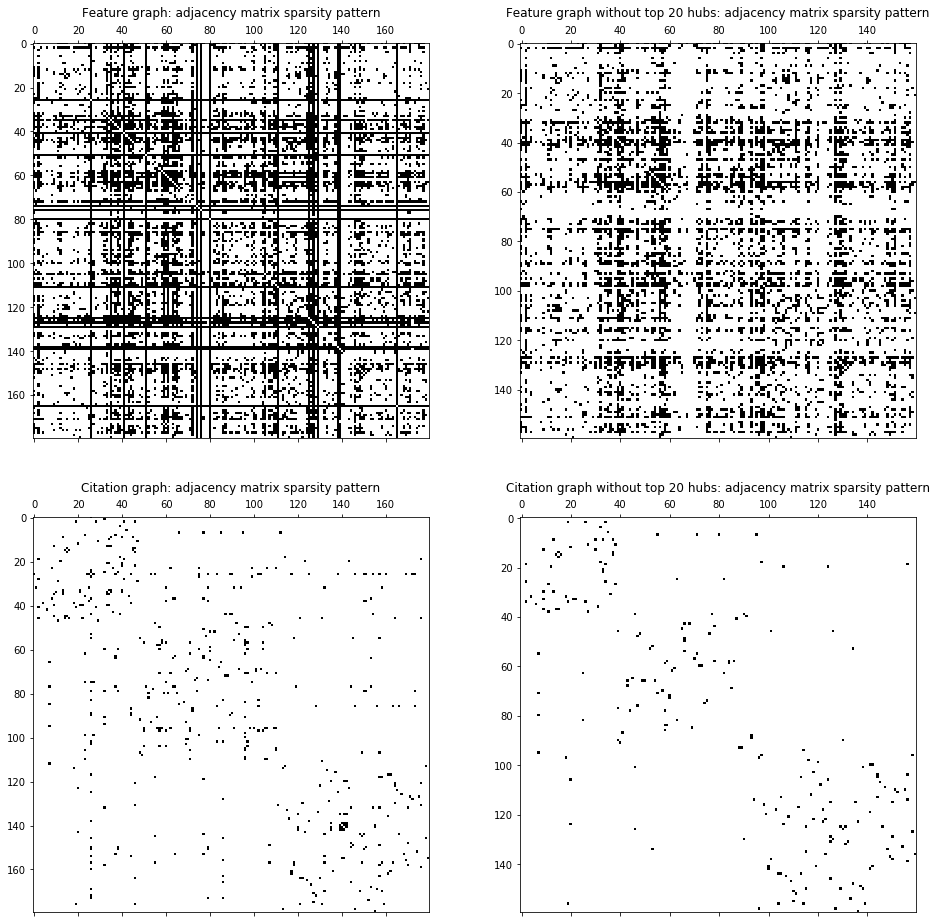

In [16]:
index = sorted(degrees_feature.argsort()[:-20][::-1])
reduced_A_feature = A_feature[index, :][:, index]
index = sorted(degrees_citation.argsort()[:-20][::-1])
reduced_A_citation = A_citation[index, :][:, index]

fig, axes = plt.subplots(2, 2, figsize=(16, 16))
axes[0, 0].set_title('Feature graph: adjacency matrix sparsity pattern')
axes[0, 0].spy(A_feature);
axes[0, 1].set_title('Feature graph without top 20 hubs: adjacency matrix sparsity pattern')
axes[0, 1].spy(reduced_A_feature);
axes[1, 0].set_title('Citation graph: adjacency matrix sparsity pattern')
axes[1, 0].spy(A_citation);
axes[1, 1].set_title('Citation graph without top 20 hubs: adjacency matrix sparsity pattern')
axes[1, 1].spy(reduced_A_citation);

Plot the new degree distribution histograms.

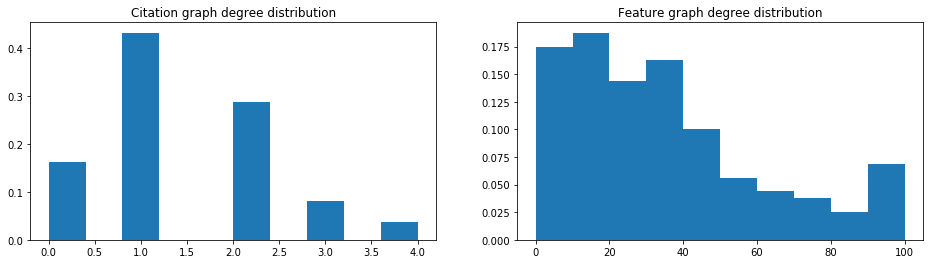

In [17]:
reduced_degrees_feat = np.sum(reduced_A_feature, axis=0).astype(int)
reduced_degrees_cit = np.sum(reduced_A_citation, axis=0).astype(int)

deg_hist_normalization = np.ones(reduced_degrees_feat.shape[0]) / reduced_degrees_feat.shape[0]

fig, axes = plt.subplots(1, 2, figsize=(16, 4))
axes[0].set_title('Citation graph degree distribution')
axes[0].hist(reduced_degrees_cit, weights=deg_hist_normalization);
axes[1].set_title('Feature graph degree distribution')
axes[1].hist(reduced_degrees_feat, weights=deg_hist_normalization);

Compute the first and second moments for the new graphs.

In [18]:
reduced_cit_moment_1 = np.sum(reduced_degrees_cit ** 1) / reduced_degrees_cit.shape[0]
reduced_cit_moment_2 = np.sum(reduced_degrees_cit ** 2) / reduced_degrees_cit.shape[0]

reduced_feat_moment_1 = np.sum(reduced_degrees_feat ** 1) / reduced_degrees_feat.shape[0]
reduced_feat_moment_2 = np.sum(reduced_degrees_feat ** 2) / reduced_degrees_feat.shape[0]


print("1st moment of reduced citation graph: ", reduced_cit_moment_1)
print("2nd moment of reduced citation graph: ", reduced_cit_moment_2)
print("1st moment of reduced feature graph: ", reduced_feat_moment_1)
print("2nd moment of reduced feature graph: ", reduced_feat_moment_2)

print(f"\nStandard deviation of reduced citation graph: {np.sqrt(reduced_cit_moment_2 - reduced_cit_moment_1**2)}")
print(f"Standard deviation of reduced feature graph: {np.sqrt(reduced_feat_moment_2 - reduced_feat_moment_1**2)}")

1st moment of reduced citation graph:  1.4
2nd moment of reduced citation graph:  2.9125
1st moment of reduced feature graph:  34.1875
2nd moment of reduced feature graph:  1870.2125

Standard deviation of reduced citation graph: 0.9759610647971569
Standard deviation of reduced feature graph: 26.484473635509545


Print the number of edges in the reduced graphs.

In [19]:
num_edges_reduced_A_citation = int(np.sum(reduced_A_citation) / 2)
num_edges_reduced_A_feature = int(np.sum(reduced_A_feature) / 2)

print(f"Number of edges in reduced citation graph: { num_edges_reduced_A_citation }")
print(f"Number of edges in reduced feature graph: { num_edges_reduced_A_feature }")

Number of edges in reduced citation graph: 112
Number of edges in reduced feature graph: 2735


Is the effect of removing the hubs the same for both networks? Look at the percentage changes for each moment. Which of the moments is affected the most and in which graph? Explain why.  

**Hint:** Examine the degree distributions.

In [20]:
print("Citation graph: decrease in the 1st moment by " + str(100-round((reduced_cit_moment_1 / cit_moment_1) * 100, 2)) + "%")
print("Citation graph: decrease in the 2nd moment by " + str(100-round((reduced_cit_moment_2 / cit_moment_2) * 100, 2)) + "%")
print("Feature graph: decrease in the 1st moment by " + str(100-round((reduced_feat_moment_1 / feat_moment_1) * 100, 2)) + "%")
print("Feature graph: decrease in the 2nd moment by " + str(100-round((reduced_feat_moment_2 / feat_moment_2) * 100, 2)) + "%")

Citation graph: decrease in the 1st moment by 50.2%
Citation graph: decrease in the 2nd moment by 80.88%
Feature graph: decrease in the 1st moment by 47.21%
Feature graph: decrease in the 2nd moment by 69.75%


**Your answer here:**

By looking at the percentage changes, we can see that both moments are more affected in the citations graph. In particular, it is greater between the second moments. It makes sense because by removing the 20 largest hubs from the citations graph, we successfuly elimate all outliers in the citations graph, i.e. a few nodes with extremely high degree compared to the rest. However, removing the 20 largest hubs from the features graph does not remove all outliers, because the degree distrbution of the reduced graph is still similar and spread.

### Question 3: Pruning, sparsity, paths

By adjusting the threshold of the euclidean distance matrix, prune the feature graph so that its number of edges is roughly close (within a hundred edges) to the number of edges in the citation graph.

In [21]:
threshold = 0.74 * mean_distance

A_feature_pruned = (distance < threshold).astype(int) - np.identity(distance.shape[0])
num_edges_feature_pruned = int(np.sum(A_feature_pruned) / 2)

print(f"Number of edges in the feature graph: {num_edges_feature}")
print(f"Number of edges in the feature graph after pruning: {num_edges_feature_pruned}")
print(f"Number of edges in the citation graph: {num_edges_citation}")

Number of edges in the feature graph: 5829
Number of edges in the feature graph after pruning: 220
Number of edges in the citation graph: 253


Check your results by comparing the sparsity patterns and total number of edges between the graphs.

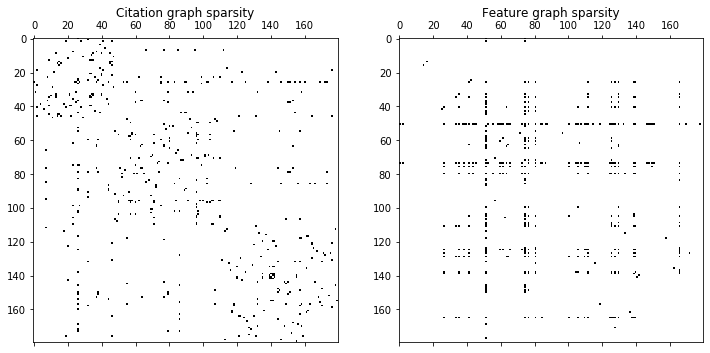

In [22]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].set_title('Citation graph sparsity')
axes[0].spy(A_citation);
axes[1].set_title('Feature graph sparsity')
axes[1].spy(A_feature_pruned);

Let $C_{k}(i,j)$ denote the number of paths of length $k$ from node $i$ to node $j$. 

We define the path matrix $P$, with entries
$ P_{ij} = \displaystyle\sum_{k=0}^{N}C_{k}(i,j). $

Calculate the path matrices for both the citation and the unpruned feature graphs for $N =10$.  

**Hint:** Use [powers of the adjacency matrix](https://en.wikipedia.org/wiki/Adjacency_matrix#Matrix_powers).

In [23]:
path_matrix_citation = sum([np.linalg.matrix_power(A_citation, k) for k in range(11)])
path_matrix_feature = sum([np.linalg.matrix_power(A_feature, k) for k in range(11)])

Check the sparsity pattern for both of path matrices.

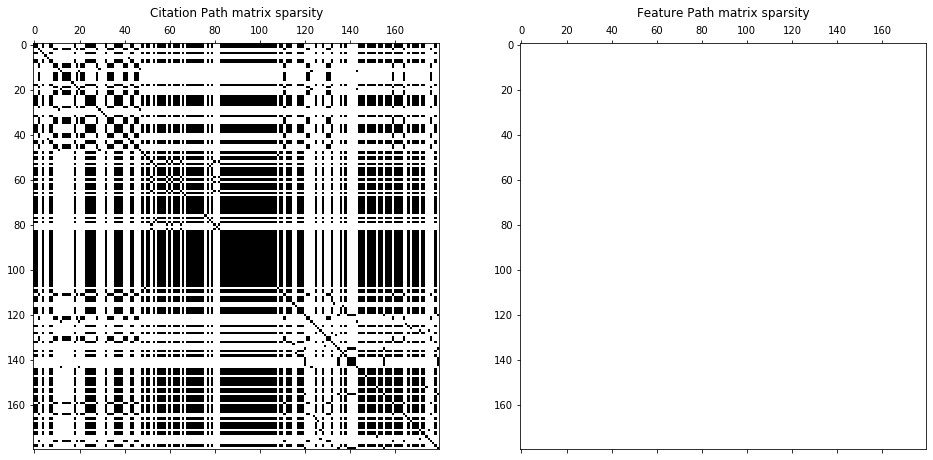

In [24]:
fig, axes = plt.subplots(1, 2, figsize=(16, 9))
axes[0].set_title('Citation Path matrix sparsity')
axes[0].spy(path_matrix_citation);
axes[1].set_title('Feature Path matrix sparsity')
axes[1].spy(path_matrix_feature);

Number of non-zero values: 0


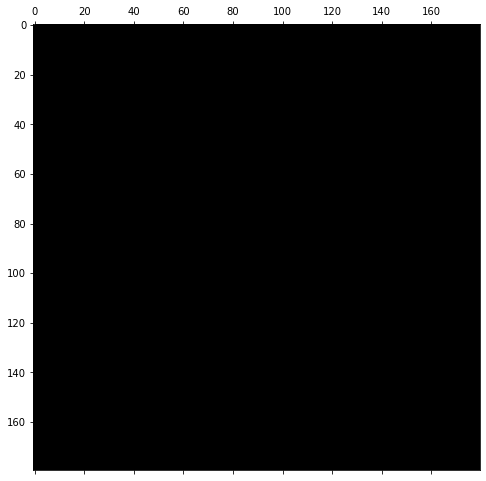

In [25]:
# We calculated, and we will also see in the following questions, that the diameter of the
# unpruned feature graph is 2. Therefore, for any n >= 2, every entry in the path matrix P is non-zero.
# For some reason, we cannot plot a path matrix, when every entry is non-zero (we get a white square).
# That is why, we changed only one value to 0, so that the .spy() function will then plot the matrix sparsity.
# Otherwise, we should get a fully black squared matrix.

print("Number of non-zero values: " + str(np.sum(path_matrix_feature == 0)))
# If we have non-zero matrix, we should observe a full black square (we have a complete graph, clique)
# Changing only one value (0, 0) to zero, we can see plot the path matrix.
path_matrix_feature[0,  0] = 0

fig, ax = plt.subplots(figsize=(8, 9))
ax.spy(path_matrix_feature)

Now calculate the path matrix of the pruned feature graph for $N=10$. Plot the corresponding sparsity pattern. Is there any difference?

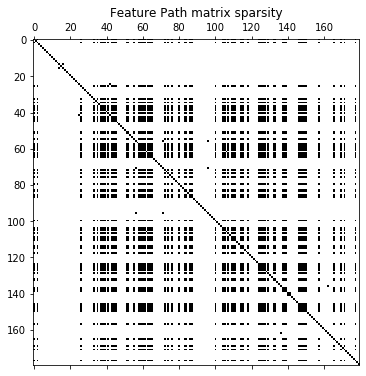

In [26]:
path_matrix_pruned = sum([np.linalg.matrix_power(A_feature_pruned, k) for k in range(11)])

plt.figure(figsize=(12, 6))
plt.title('Feature Path matrix sparsity')
plt.spy(path_matrix_pruned);

**Your answer here:**

We observe that in the pruned feature graph, there are quite a few isolated nodes (nodes with IDs between a little more than 0 and a little more than 20). Thus whole graph is disconnected, and the diameter cannot be calculated.

Describe how you can use the above process of counting paths to determine whether a graph is connected or not. Is the original (unpruned) feature graph connected?

**Your answer here:**

Let $P$ be an adjacency matrix for a graph $G$ and $X_s = \sum_{k=0}^{s}P^{k}$. Then $G$ is connected iff every entry in $X_{|N|-1}$ matrix is non-zero, where $N$ is the set of nodes of the graph $G$ and $|N|$ is size of the set, i.e. number of nodes in $G$. It follows from the fact that the diameter of $G$ is at most $|N|-1$. A zero entry in $X_{|N|-1}$ means there is not a path of any length in $\{0, 1, \dots, |N|-1\}$, thus there exist a pair of nodes which belong to different components and therefore, the graph is disconnected.

If the graph is connected, how can you guess its diameter using the path matrix?

**Your answer here:**

Diameter of a connected graph $G$ is the smallest $n \in \{0, 1, 2, \dots, |N|-1\}$ for which every entry in $X_n$ is non-zero. We are using the definition of $X_n$ explained in the previous answer.

If any of your graphs is connected, calculate the diameter using that process.

In [27]:
diameter = -1

# We can furthermore speed up the process (at least, asymptotically)
# by performing binary serach for k on the range [0, |N|-1].
# Empirically, the naive solution written below is much faster.
for k in range(A_feature.shape[0]):
    if np.min(sum([np.linalg.matrix_power(A_feature, k) for k in range(k + 1)])) != 0:
        diameter = k
        break

print(f"The diameter of the feature graph is {diameter}.")

The diameter of the feature graph is 2.


Check if your guess was correct using [NetworkX](https://networkx.github.io/documentation/stable/reference/algorithms/generated/networkx.algorithms.distance_measures.diameter.html).
Note: usage of NetworkX is only allowed in this part of Section 1.

In [28]:
import networkx as nx
feature_graph = nx.from_numpy_matrix(A_feature)
print(f"Diameter according to networkx: {nx.diameter(feature_graph)}")

Diameter according to networkx: 2


## Section 2: Network Models

In this section, you will analyze the feature and citation graphs you constructed in the previous section in terms of the network model types.
For this purpose, you can use the NetworkX libary imported below.

In [29]:
import networkx as nx

Let us create NetworkX graph objects from the adjacency matrices computed in the previous section.

In [30]:
G_citation = nx.from_numpy_matrix(A_citation)
print('Number of nodes: {}, Number of edges: {}'. format(G_citation.number_of_nodes(), G_citation.number_of_edges()))
print('Number of self-loops: {}, Number of connected components: {}'. format(G_citation.number_of_selfloops(), nx.number_connected_components(G_citation)))

Number of nodes: 180, Number of edges: 253
Number of self-loops: 0, Number of connected components: 26


In the rest of this assignment, we will consider the pruned feature graph as the feature network.

In [31]:
G_feature = nx.from_numpy_matrix(A_feature_pruned)
print('Number of nodes: {}, Number of edges: {}'. format(G_feature.number_of_nodes(), G_feature.number_of_edges()))
print('Number of self-loops: {}, Number of connected components: {}'. format(G_feature.number_of_selfloops(), nx.number_connected_components(G_feature)))

Number of nodes: 180, Number of edges: 220
Number of self-loops: 0, Number of connected components: 114


### Question 4: Simulation with Erdős–Rényi and Barabási–Albert models

Create an Erdős–Rényi and a Barabási–Albert graph using NetworkX to simulate the citation graph and the feature graph you have. When choosing parameters for the networks, take into account the number of vertices and edges of the original networks.

The number of nodes should exactly match the number of nodes in the original citation and feature graphs.

In [32]:
assert len(G_citation.nodes()) == len(G_feature.nodes())
n = len(G_citation.nodes())
n

180

The number of match shall fit the average of the number of edges in the citation and the feature graph.

In [33]:
m = np.round((G_citation.size() + G_feature.size()) / 2)
m

236.0

How do you determine the probability parameter for the Erdős–Rényi graph?

**Your answer here:**

We determine the probability parameter using the following equation:

$p = \frac{\langle L \rangle}{\frac{N(N-1)}{2}}$.

- $\langle L \rangle$ - expected number of links
- $p$ - probability that two nodes are conected
- $N$ - number of nodes

In [34]:
p = G_citation.size() / (n * (n - 1) / 2)
G_er = nx.erdos_renyi_graph(n, p)

Check the number of edges in the Erdős–Rényi graph.

In [35]:
print('My Erdos-Rényi network that simulates the citation graph has {} edges.'.format(G_er.size()))

My Erdos-Rényi network that simulates the citation graph has 259 edges.


How do you determine the preferential attachment parameter for Barabási–Albert graphs?

**Your answer here:**

We initially start with $m_0$ nodes, where the inital edges are chosen arbitrarily and each node has at least one edge. We can say that there are initially $m_0$ edges. Then at each step we add a node that we connect with $q$ of the previously added nodes. At time step $t$, there are total of $m_0 + qt$ edges. Let us say that we want to create a graph with $N$ nodes. Then, we choose $t = N - m_0$ since at each time step $t$ we have $m_0 + t$ nodes.

Let $E$ be set of edges in our graph, and let $|E|$ be size of the set. Then for our graph, it must hold that $|E| = m_0 + q(N - m_0)$. We get the equation for $q$ as follows:

$q = \frac{|E| - m_0}{N - m_0}$.

Since we have a relatively sparse graph with 180 nodes and 253 edges, the only reasonable possibilites for $q$ are $1$ and $2$. The first value creates a tree, and the second creates a graph with 356 edges, which is denser than initial. The first value is closer to the real number of edges, so we chose $q = 1$.

In [36]:
m0 = 1
q = (G_citation.size() - m0) // (len(G_citation.nodes()) - m0)
# m0 = 1 => q = 1
G_ba = nx.barabasi_albert_graph(n, q)

Check the number of edges in the Barabási–Albert graph.

In [37]:
print('My Barabási-Albert network that simulates the citation graph has {} edges.'.format(G_ba.size()))

My Barabási-Albert network that simulates the citation graph has 179 edges.


### Question 5: Giant Component

Check the size of the largest connected component in the citation and feature graphs.

In [38]:
giant_citation = max(nx.connected_component_subgraphs(G_citation), key=len)
print('The giant component of the citation graph has {} nodes and {} edges.'.format(giant_citation.number_of_nodes(), giant_citation.size()))

The giant component of the citation graph has 102 nodes and 172 edges.


In [39]:
giant_feature = max(nx.connected_component_subgraphs(G_feature), key=len)
print('The giant component of the feature graph has {} nodes and {} edges.'.format(giant_feature.number_of_nodes(), giant_feature.size()))

The giant component of the feature graph has 60 nodes and 213 edges.


Check the size of the giant components in the generated Erdős–Rényi graph.

In [40]:
giant_er = max(nx.connected_component_subgraphs(G_er), key=len)
print('The giant component of the Erdos-Rényi network has {} nodes and {} edges.'.format(giant_er.number_of_nodes(), giant_er.size()))

The giant component of the Erdos-Rényi network has 163 nodes and 256 edges.


Let us match the number of nodes in the giant component of the feature graph by simulating a new Erdős–Rényi network.
How do you choose the probability parameter this time? 

**Hint:** Recall the expected giant component size from the lectures.

**Your answer here:**

First, we find the in which regime the graph is. For that, we need to find the size of the giant component as $\frac{N_G}{N}$. The graph in our case is in the supercritical regime, thus the average degree $\langle k \rangle \approx \frac{N_G}{N} + 1$. The probability of edge creation is $p = \frac{\langle k \rangle}{N - 1}$.

In [41]:
NgN = giant_feature.number_of_nodes() / G_feature.number_of_nodes()
k = NgN + 1
p_new = k / (G_feature.number_of_nodes() - 1)
G_er_new = nx.erdos_renyi_graph(n, p_new)

Check the size of the new Erdős–Rényi network and its giant component.

In [42]:
print('My new Erdos Renyi network that simulates the citation graph has {} edges.'.format(G_er_new.size()))
giant_er_new = max(nx.connected_component_subgraphs(G_er_new), key=len)
print('The giant component of the new Erdos-Rényi network has {} nodes and {} edges.'.format(giant_er_new.number_of_nodes(), giant_er_new.size()))

My new Erdos Renyi network that simulates the citation graph has 135 edges.
The giant component of the new Erdos-Rényi network has 104 nodes and 105 edges.


### Question 6: Degree Distributions

Recall the degree distribution of the citation and the feature graph.

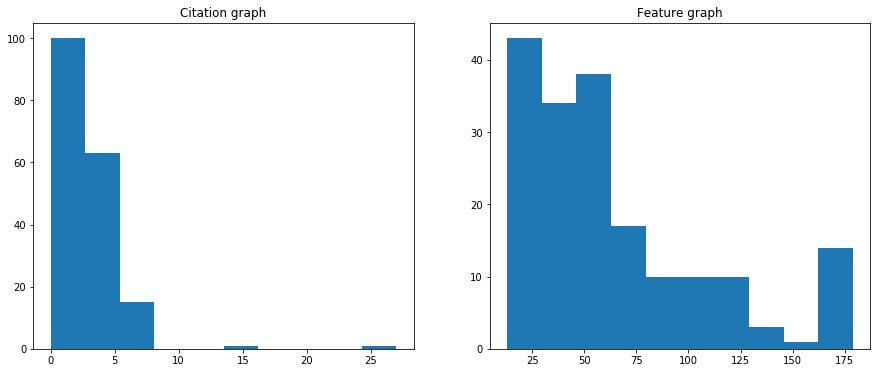

In [43]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
axes[0].set_title('Citation graph')
citation_degrees = np.sum(A_citation, axis = 0)
axes[0].hist(citation_degrees);
axes[1].set_title('Feature graph')
feature_degrees = np.sum(A_feature, axis = 0).astype(int)
axes[1].hist(feature_degrees);

What does the degree distribution tell us about a network? Can you make a prediction on the network model type of the citation and the feature graph by looking at their degree distributions?

**Your answer here:**

The degree distribution tells us how sparse or dense, robust, and what network model the a network follows. Initially, looks like the degree distribution of the citation graph follows an exponentital distribution since we have an extremely small number of nodes with high degree, and the degree distribution of the feature graph follows a power law distribution since we have quite a few nodes with high degree. However, we plotted the distributions on log scale to test the exponential distribution and log-log scale to test the power law distrubtion. For both distributions, we got far more different than 'straight' lines, so our initial assumption is wrong. We cannot make predictions about the degree distributions of these networks.

Now, plot the degree distribution historgrams for the simulated networks.

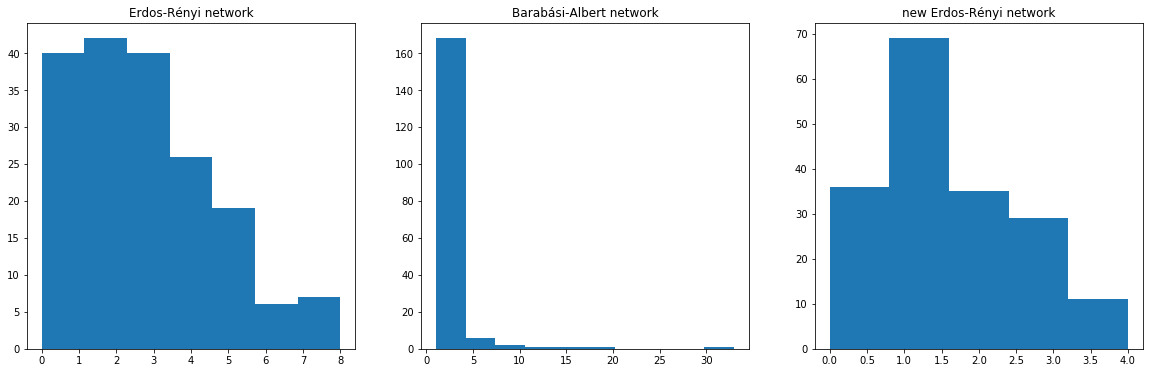

In [44]:
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
axes[0].set_title('Erdos-Rényi network')
er_degrees = np.sum(nx.adjacency_matrix(G_er), axis = 1)
axes[0].hist(er_degrees, bins=7);
axes[1].set_title('Barabási-Albert network')
ba_degrees = np.sum(nx.adjacency_matrix(G_ba), axis = 1)
axes[1].hist(ba_degrees);
axes[2].set_title('new Erdos-Rényi network')
er_new_degrees = np.sum(nx.adjacency_matrix(G_er_new), axis = 1)
axes[2].hist(er_new_degrees, bins=5);

In terms of the degree distribution, is there a good match between the citation and feature graphs and the simulated networks?
For the citation graph, choose one of the simulated networks above that match its degree distribution best. Indicate your preference below.

**Your answer here:** 

There seems to be a good match between the simulated Barabási-Albert network and the citation graph. We could say that Erdos-Rényi network is closest to the feature graph from the 3 simulated network, with the most notable difference being the less nodes with high degrees.


You can also simulate a network using the configuration model to match its degree disctribution exactly. Refer to [Configuration model](https://networkx.github.io/documentation/stable/reference/generated/networkx.generators.degree_seq.configuration_model.html#networkx.generators.degree_seq.configuration_model).

Let us create another network to match the degree distribution of the feature graph. 

In [45]:
G_config = nx.configuration_model(feature_degrees) 
print('Configuration model has {} nodes and {} edges.'.format(G_config.number_of_nodes(), G_config.size()))

Configuration model has 180 nodes and 5829 edges.


Does it mean that we create the same graph with the feature graph by the configuration model? If not, how do you understand that they are not the same?

In [46]:
print('Is the feature graph connected?', nx.is_connected(G_feature))
print('Diameter of G_config:', nx.diameter(G_config))

Is the feature graph connected? False
Diameter of G_config: 3


**Your answer here:** 

No. The configuration model creates many parallel edges and self loops. We can abuse the observation that diameter of such a graph is low. In particular, the configuration model graph has a diameter 3 whereas our initial feature graph is disconnected.

### Question 7: Clustering Coefficient

Let us check the average clustering coefficient of the original citation and feature graphs. 

In [47]:
nx.average_clustering(G_citation)

0.26935863519196857

In [48]:
nx.average_clustering(G_feature)

0.2155615104561419

What does the clustering coefficient tell us about a network? Comment on the values you obtain for the citation and feature graph.

**Your answer here:**

The local clustering coefficient for a specific node tells us how densely connected its neighbours are. The averate clustering coefficient is average of the local clustering coefficients for every node and it represents how densely connected the components of the graph are. We have on average $\sim 27\%$ and $\sim 21\%$ of a clique for each connected component in the citation and feature graph respectively. A fixed percentage indicates higher numer of edges for larger cliques.

Now, let us check the average clustering coefficient for the simulated networks.

In [49]:
nx.average_clustering(G_er)

0.009603174603174605

In [50]:
nx.average_clustering(G_ba)

0.0

In [51]:
nx.average_clustering(nx.Graph(G_config))

0.42222856349453325

Comment on the values you obtain for the simulated networks. Is there any good match to the citation or feature graph in terms of clustering coefficient?

**Your answer here:**

The Erdős–Rényi simulated network has a low clustering coefficient because it is in the supercritical region, where there is one giant component, which looks like a tree and is sparsely connected. Therefore, we can say that all connected components are sparsely connected, and thus, we cannot expect a high clustering coefficient.

Our Barabási–Albert simulation network has a preferential attachment parameter $1$. It means, that he graph is basically a tree. Any (local, average, global) clustering coefficient of a tree is 0.

The Configuration model simulated network has a high clustering coefficient because we checked that the diameter of the graph is 3. Because of the many self loops and parallel edges, the network is one giant component that is densely connected, and therefore, it has a high averate clustering coefficient.

Check the other [network model generators](https://networkx.github.io/documentation/networkx-1.10/reference/generators.html) provided by NetworkX. Which one do you predict to have a better match to the citation graph or the feature graph in terms of degree distribution and clustering coefficient at the same time? Justify your answer.

**Your answer here:**

If we assume that the citation graph follows a power law distribution, we can simualte it to some extend with a random power law tree or Barabasi-Albert model. Since the average degree in the citation graph is $1.4$ and we can only choose integer value for the degree in both models, we chose $1$ since it's closer to the real value. We chose gamma (the parameter for the power law distribution) as slope of the line in the log-log scale.

In [52]:
print('Degree distrubtion:\n', 
      pd.DataFrame(citation_degrees).rename(columns = {0: 'deg'})['deg'].value_counts())

print('Gamma:', (np.log(18) - np.log(33)) / (np.log(4) - np.log(3)))
print('However, gamma = 2.1 does not reliable find a proper tree after many simulations, so we chose gamma = 2.4')

Degree distrubtion:
 1.0     49
2.0     41
3.0     33
4.0     18
5.0     12
0.0     10
6.0      7
8.0      5
7.0      3
14.0     1
27.0     1
Name: deg, dtype: int64
Gamma: -2.106964116340311
However, gamma = 2.1 does not reliable find a proper tree after many simulations, so we chose gamma = 2.4


If you find a better fit, create a graph object below for that network model. Print the number of edges and the average clustering coefficient. Plot the histogram of the degree distribution.

In [53]:
simulated_citation_graph = nx.random_powerlaw_tree(G_citation.number_of_nodes(), gamma = 2.4, tries = 1000000)

print('Original citations graph')
print('Nodes:', G_citation.number_of_nodes())
print('Edges:', G_citation.number_of_edges())
print('Average clustering coefficient:', nx.average_clustering(G_citation))

print('\nSimulated citations graph')
print('Nodes:', simulated_citation_graph.number_of_nodes())
print('Edges:', simulated_citation_graph.number_of_edges())
print('Average clustering coefficient:', nx.average_clustering(simulated_citation_graph))

Original citations graph
Nodes: 180
Edges: 253
Average clustering coefficient: 0.26935863519196857

Simulated citations graph
Nodes: 180
Edges: 179
Average clustering coefficient: 0.0


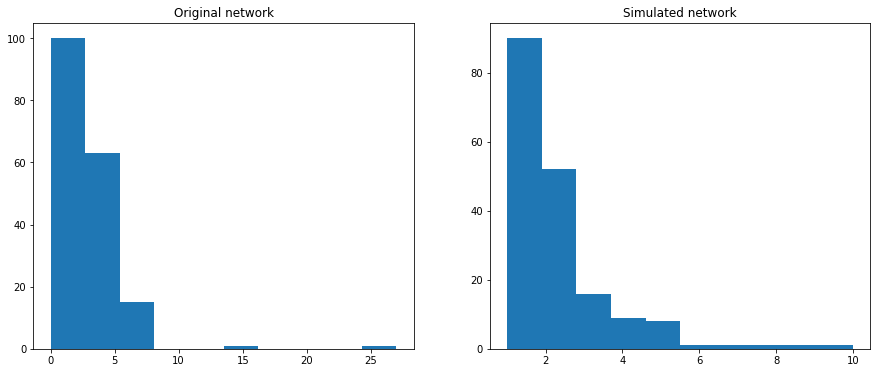

In [54]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
axes[0].set_title('Original network')
axes[0].hist(np.sum(nx.adjacency_matrix(G_citation), axis = 1));
axes[1].set_title('Simulated network')
axes[1].hist(np.sum(nx.adjacency_matrix(simulated_citation_graph), axis = 1));

Comment on the similarities of your match.

**Your answer here:**

There is no way we can match the clustering coefficient. In fact, our simulated network is always a tree. Any clustering coefficient of a tree is 0, thus we can never match the clustering coefficient of a non-tree graph.

The degree distribution fluctuates, but the general form seems to match. Note that we used gamma parameter 2.4 instead of 2.1 because the nx function fails to find tree for the real parameter. In general, our degree distribution is more steep, which is reasonable, since increasing the gamma parameter makes the distribution narrower (small degrees have higher probability to get sampled).